In [1]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
num_epochs = 10
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length
num_layers = 3

In [3]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

In [4]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [num_layers, 2, batch_size, state_size])

state_per_layer_list = tf.unstack(init_state, axis=0)
rnn_tuple_state = tuple(
    [tf.contrib.rnn.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
     for idx in range(num_layers)]
)

W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32) # useless 
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)  # useless 

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [5]:
# Forward passes
cell = tf.contrib.rnn.LSTMCell(state_size, state_is_tuple=True)
cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=0.5)
cell = tf.contrib.rnn.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
states_series, current_state = tf.nn.dynamic_rnn(cell, tf.expand_dims(batchX_placeholder, -1), initial_state=rnn_tuple_state)
states_series = tf.reshape(states_series, [-1, state_size])

In [7]:
logits = tf.matmul(states_series, W2) + b2 #Broadcasted addition
labels = tf.reshape(batchY_placeholder, [-1])

logits_series = tf.unstack(tf.reshape(logits, [batch_size, truncated_backprop_length, 2]), axis=1)
predictions_series = [tf.nn.softmax(logit) for logit in logits_series]

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

In [8]:
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


New data, epoch 0
Step 0 Batch loss 0.694067
Step 100 Batch loss 0.707042
Step 200 Batch loss 0.692209
Step 300 Batch loss 0.693985
Step 400 Batch loss 0.688841
Step 500 Batch loss 0.681326
Step 600 Batch loss 0.630015
New data, epoch 1
Step 0 Batch loss 0.639133
Step 100 Batch loss 0.591654
Step 200 Batch loss 0.592308
Step 300 Batch loss 0.588101
Step 400 Batch loss 0.428836
Step 500 Batch loss 0.496495
Step 600 Batch loss 0.380511
New data, epoch 2
Step 0 Batch loss 0.402051
Step 100 Batch loss 0.346155
Step 200 Batch loss 0.225895
Step 300 Batch loss 0.276614
Step 400 Batch loss 0.176931
Step 500 Batch loss 0.216287
Step 600 Batch loss 0.196744
New data, epoch 3
Step 0 Batch loss 0.398035
Step 100 Batch loss 0.168695
Step 200 Batch loss 0.21753
Step 300 Batch loss 0.224137
Step 400 Batch loss 0.149103
Step 500 Batch loss 0.172648
Step 600 Batch loss 0.147136
New data, epoch 4
Step 0 Batch loss 0.538451
Step 100 Batch loss 0.255325
Step 200 Batch loss 0.145579
Step 300 Batch loss 0.

KeyboardInterrupt: 

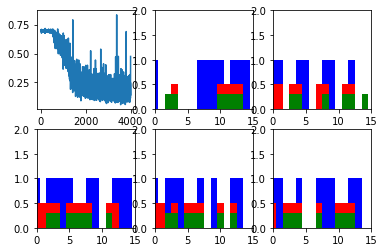

In [10]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()

        _current_state = np.zeros((num_layers, 2, batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder: batchX,
                    batchY_placeholder: batchY,
                    init_state: _current_state
                })


            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Batch loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()